# Домашнее задание 5. Линейные модели

In [1]:
import random as pr
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import sklearn.cross_validation as cv
import sklearn.metrics as sm

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\ww\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Зачитываем результат 4 домашки

In [2]:
data = np.load("out_5_dat.npz")
users = data["users"]
X_dataset = data["data"].reshape(1,)[0]

Зачитываем категории пользователей

In [3]:
TRAINING_SET_PATH = "train.csv"
TESTING_SET_PATH = "test.csv"
df_users_train = pd.read_csv(TRAINING_SET_PATH, sep=",", header=0)
df_users_ex = pd.read_csv(TESTING_SET_PATH, sep=",", header=0)
df_users_ex['cls'] = None
df_users = pd.concat([df_users_train, df_users_ex])

Модель строим для пользователей из twitter_train, нужно выбрать этих пользователей из матрицы из 4 ДЗ:

In [4]:
# TODO check this code
train_users = df_users_train["uid"].values
ix = np.in1d(users, train_users).reshape(users.shape)
X = X_dataset[:len(train_users)]

Формируем целевую переменную: Делаем join списка пользователей из ДЗ4 с обучающей выборкой.

In [5]:
train_users_ids = users[np.where(ix)]
Y_df = df_users_train.set_index(df_users_train['uid'].values)
filtered_Y = Y_df.ix[train_users_ids]
Y = df_users_train['cls'].values
print "Resulting training set: (%dx%d) feature matrix, %d target vector" % (X.shape[0], X.shape[1], Y.shape[0])

Resulting training set: (7199x201885) feature matrix, 7199 target vector


Чтобы исследовать, как ведут себя признаки, построим распределение количества ненулевых признаков у пользователей, чтобы убедиться, что он удовлетворяет закону Ципфа. Для этого построим гистограмму в логарифмических осях. [Подсказка](http://anokhin.github.io/img/sf1.png)

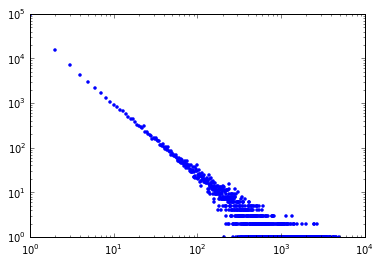

In [31]:
import collections
from pylab import scatter
import pylab
import matplotlib.pyplot as plt

freq_dict = collections.defaultdict(int)

def draw_log_hist(X):
    """Draw tokens histogram in log scales"""
    features_counts = np.zeros(X.shape[1], dtype=np.int32)
    Xc = X.tocsc()

    for feature in xrange(X.shape[1]):
        frequency = Xc[:,feature].size
        features_counts[feature] = frequency
        freq_dict[frequency] += 1
    
    fig = plt.figure()
    ax = plt.gca()
    ax.plot(freq_dict.keys(), freq_dict.values(), 'o', c='blue', markeredgecolor='none', markersize=3.5)
    ax.set_yscale('log')
    ax.set_xscale('log')
    pylab.show()
    
    return features_counts

features_counts = draw_log_hist(X)

Проведем отбор признаков. В самом простом случае просто удаляем признаки, имеющие ненулевое значение у менее, чем 100 пользователей.

In [7]:
X1 = X.tocsc()[:, features_counts > 100].toarray()

Вариант задания генерируется на основании вашего ника в техносфере.

In [8]:
USER_NAME = "a.slivkina"
OPTIMIZATION_ALGORITHMS = ["stochastic gradient descent", "Newton method"]
REGULARIZATIONS = ["L1", "L2"]

print "My homework 5 algorithm is: Logistic regression with %s regularization optimized by %s" % (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    OPTIMIZATION_ALGORITHMS[hash(USER_NAME[::-1]) % 2]
)

My homework 5 algorithm is: Logistic regression with L1 regularization optimized by stochastic gradient descent


Реализуем выбранный алгоритм

In [9]:
def sigmoid(z):
    return (1.0 / (1 + exp(-z)))

class LogisticRegression():
    
    def __init__(self, eps=1e-3, max_iter=100, C=1.0):
        self.eps = eps
        self.max_iter = max_iter
        self.C = C
        
    def compute_cost(self, X, Y):
        N=len(Y)
        y=np.array(Y)
        self.theta=np.random.uniform(-0.1, 0.1, size=X.shape[1])
        h = np.array(map( sigmoid, np.dot(X, self.theta)))
        J = (1./N) * (np.dot(-(y).T,(log(h))) - np.dot((1-y).T, (log(1-h))))
        return self.C * J  + np.sum(np.abs(self.theta)) 
    
    def cost_function_gradient(self, X, Y):
        N=len(Y)
        gradient = np.zeros(X.shape[1] + 1)
        theta=np.random.uniform(-0.1, 0.1, size=X.shape[1])
        self.theta = np.array(self.theta)
        scalar_product = np.dot(X, self.theta.T)
        h = np.array(map( sigmoid, np.dot(X, self.theta.T)))
        gradient = np.dot((h - Y),X)
        gradient = gradient / N
        return self.C *gradient +\
                np.sum(np.sign(self.theta))
    
    def fit(self, X, Y=None):
        
        self.theta, self.new_theta = X.shape
        self.theta = np.random.uniform(-0.1, 0.1, size=X.shape[1])
        self.new_theta = np.zeros(self.max_iter + 2)
        self.new_theta[0] = self.compute_cost(X, Y) 
        i=0
    
        while i<=self.max_iter:
            i=i+1
            self.theta += self.eps * self.cost_function_gradient(X, np.array(Y))
            self.new_theta[i] = self.compute_cost(X, Y) 

        return self
    
    def predict_proba(self, X):
        return 1 / (1 + np.exp(-np.dot(X, self.theta)))

Реализуем метрику качества, используемую в соревновании: площадь под ROC кривой

In [25]:
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

model =  LogisticRegression(max_iter=50, eps=0.001, C=1)
D, t = make_classification(n_samples=6000, n_features=30, n_informative=12, n_classes=2)
sc = StandardScaler()
model.fit(sc.fit_transform(D[:3500]), t[:3500]) 
prediction = model.predict_proba(sc.transform(D[3500:])) 
print ("AUC-ROC = ", roc_auc_score(t[:size(prediction)], prediction))

clf = RandomForestClassifier(n_estimators=100, max_depth=10, n_jobs=-1)
clf.fit(X1[:3500], Y[:3500])
prediction2 = clf.predict_proba(X1[3500:])[:, 1]
print ("AUC-ROC = ", roc_auc_score(Y[:size(prediction)], prediction))

('AUC-ROC = ', 0.49948477889654358)
('AUC-ROC = ', 0.49392670972859659)


Разделим выборку с помощью методики кросс-валидации для того, чтобы настроить параметр регуляризации $C$

In [27]:
C = [0.0, 0.01, 0.1, 1, 10, 100, 1000, 10000]
SIZE = 400
auc_scores = dict()

def CrossValidation(X, Y, size, cross_val_id):
    ind = [idx >= size * cross_val_id and idx < size * (cross_val_id + 1) for idx in range(X.shape[0])]
    array_ind = np.array(ind)
    not_ind_array = np.logical_not(array_ind)
    X_1 = X[np.where(array_ind)]
    X_2 = X[np.where(not_ind_array)]
    Y_1 = Y[np.where(array_ind)]
    Y_2 = Y[np.where(not_ind_array)]
    return (X_1, Y_1, X_2, Y_2)

def select_reg_parameter(C, X, Y):
    selected_index = 0
    best_auc_score = 0.0
    for i in xrange(len(C)):
        C_value = C[i]
        if (X1.shape[0] % SIZE > 0):
            pieces = X1.shape[0] / SIZE + 1  
        else: pieces = 0
        local_auc_score = 0.0
        converges = False
        for j in xrange(pieces):
            X_1, Y_2, X_trn, Y_trn = CrossValidation(X1, Y, SIZE, j)
            converges = model.fit(X_trn, Y_trn)
            if converges:
                Y_3 = model.predict_proba(X_1)
                local_auc_score = local_auc_score + roc_auc_score(Y_2, Y_3)
            else:
                local_auc_score = 0.0
                break
                
        local_auc_score = local_auc_score / pieces
        auc_scores[i] = local_auc_score
        
        if local_auc_score > best_auc_score:
            selected_index = i
            best_auc_score = local_auc_score
            
    return selected_index

index = select_reg_parameter(C, X1, Y)
print "Selected reg. param is ", index


Selected reg. param is  7


Выбираем наилучшее значение $C$, и классифицируем неизвестных пользователей и строим ROC-кривую

2159
Area under the ROC curve : 0.489560


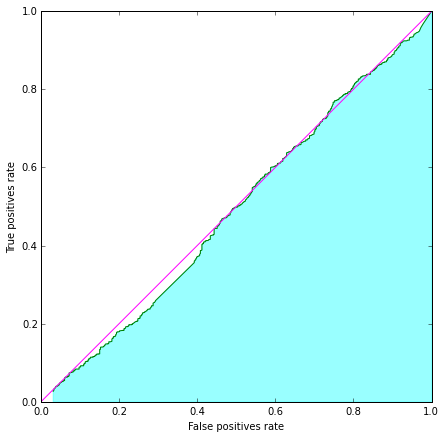

In [34]:
LEVELS = 2000

def much_more(x, l):
    return 1 if x >= l else 0

much_more_vector = np.vectorize(much_more)

def classify(X, Y, test_size, C):
    tpr = np.zeros(LEVELS)
    fpr = np.zeros(LEVELS)
    validation_size = int(Y.shape[0] * test_size)
    X_1, Y_2, X_trn, Y_trn = CrossValidation(X, Y, validation_size, 0)
    model.fit(X_trn, Y_trn)
    for l in xrange(LEVELS):
        
        limit = float(l) / float(LEVELS)
        Y_binarized = much_more_vector(Y_3, limit)
        true_positives = Y_binarized * Y_2
        
        false_negatives = np.logical_not(Y_binarized).astype(np.int32) * Y_2
        tpr[l] = float(np.sum(true_positives)) / (np.sum(true_positives) + np.sum(false_negatives))
        
        true_negatives = np.logical_not(Y_binarized + false_negatives).astype(np.int32)
        false_positives = Y_binarized - true_positives
        fpr[l] = float(np.sum(false_positives)) / (np.sum(false_positives) + np.sum(true_negatives))
        
        roc_auc = roc_auc_score(Y_2, Y_3)    
    
    return tpr, fpr, roc_auc

tpr, fpr, roc_auc = classify(X1, Y, 0.3, C[index])

print "Area under the ROC curve : %f" % roc_auc

def plot_roc_curve(tpr, fpr, roc_auc):
    """Plot ROC curve"""
    
    fig = plt.figure(figsize=(7, 7))
    ax = plt.gca()
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    plt.plot(fpr, tpr, color='green')
    plt.plot([0, 1], [0, 1], color='magenta')
    pl.fill_between(fpr, tpr, alpha=0.4, color='cyan')
    plt.xlabel("False positives rate")
    plt.ylabel("True positives rate")
    plt.show()
    
    return

plot_roc_curve(tpr, fpr, roc_auc)

С помощью полученной модели предсказываем категории для неизвестных пользователей из соревнования и загружаем на kaggle в нужном формате. ДЗ принимается только при наличии загруженных данных на kaggle.